In [1]:
import numpy as np
import os
# Polars is an alternative to Pandas. Experimentation!
import polars as pl
# An initial solution for generation
import sdv
from tqdm import tqdm

from sdv.evaluation import multi_table, single_table
from sdv.metadata import SingleTableMetadata, MultiTableMetadata
from sdv.single_table import GaussianCopulaSynthesizer
from sdv.multi_table import HMASynthesizer

from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [2]:
ad_data_orig = pl.scan_csv("data/train_data_ads.csv", infer_schema_length = 10000)
feed_data_orig = pl.scan_csv("data/train_data_feeds.csv", infer_schema_length = 10000)

In [3]:
# Convert `pt_d` to a datetime
ad_data = ad_data_orig.with_columns(
    pl.col("ad_click_list_v001").str.split("^").list.eval(pl.element().cast(pl.Int64)),
    pl.col("ad_click_list_v002").str.split("^").list.eval(pl.element().cast(pl.Int64)),
    pl.col("ad_click_list_v003").str.split("^").list.eval(pl.element().cast(pl.Int64)),
    pl.col("u_newsCatInterestsST").str.split("^").list.eval(pl.element().cast(pl.Int64)),
    pl.col("pt_d").cast(pl.String).str.to_datetime("%Y%m%d%H%M"),
)

In [4]:
feed_data = feed_data_orig.with_columns(
    pl.col("u_newsCatInterests").str.split("^").list.eval(pl.element().cast(pl.Int64)),
    pl.col("u_newsCatDislike").str.split("^").list.eval(pl.element().cast(pl.Int64)),
    pl.col("u_newsCatInterestsST").str.split("^").list.eval(pl.element().cast(pl.Int64)),
    pl.col("u_click_ca2_news").str.split("^").list.eval(pl.element().cast(pl.Int64)),
    pl.col("e_et").cast(pl.String).str.to_datetime("%Y%m%d%H%M"),
)
feed_data = feed_data.rename({ "u_userId": "user_id" })
feed_data = feed_data.with_columns(
    pl.col("i_cat").is_in(pl.col("u_newsCatInterests")).alias("Interested"),
    pl.col("i_cat").is_in(pl.col("u_newsCatDislike")).alias("Disliked"),
    pl.col("i_cat").is_in(pl.col("u_newsCatInterestsST")).alias("InterestedST"),
)

In [5]:
ad_data.fetch()

log_id,label,user_id,age,gender,residence,city,city_rank,series_dev,series_group,emui_dev,device_name,device_size,net_type,task_id,adv_id,creat_type_cd,adv_prim_id,inter_type_cd,slot_id,site_id,spread_app_id,hispace_app_tags,app_second_class,app_score,ad_click_list_v001,ad_click_list_v002,ad_click_list_v003,ad_close_list_v001,ad_close_list_v002,ad_close_list_v003,pt_d,u_newsCatInterestsST,u_refreshTimes,u_feedLifeCycle
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,list[i64],list[i64],list[i64],str,str,str,datetime[μs],list[i64],i64,i64
373250,0,100005,3,2,16,147,2,32,6,35,312,2117,7,14339,19319,6,1846,4,46,1,162,47,14,10.0,"[30157, 30648, … 31706]","[2066, 1776, 1036]","[114, 219, 312]","""24107""","""1218""","""173""",2022-06-03 03:26:00,"[39, 220, 16]",0,15
373253,1,100005,3,2,16,147,2,32,6,35,312,2117,7,11923,21714,8,1060,4,37,1,344,20,13,10.0,"[30157, 30648, … 31706]","[2066, 1776, 1036]","[114, 219, 312]","""24107""","""1218""","""173""",2022-06-03 03:26:00,"[39, 220, 16]",0,15
373252,1,100005,3,2,16,147,2,32,6,35,312,2117,7,11923,21714,8,1060,4,37,1,344,20,13,10.0,"[30157, 30648, … 31706]","[2066, 1776, 1036]","[114, 219, 312]","""24107""","""1218""","""173""",2022-06-03 03:26:00,"[39, 220, 16]",0,15
373251,0,100005,3,2,16,147,2,32,6,35,312,2117,7,28665,20163,8,1542,4,47,1,152,49,17,10.0,"[30157, 30648, … 31706]","[2066, 1776, 1036]","[114, 219, 312]","""24107""","""1218""","""173""",2022-06-03 03:26:00,"[39, 220, 16]",0,15
373255,0,100005,3,2,16,147,2,32,6,35,312,2117,7,34041,13608,8,1036,4,44,1,312,43,18,10.0,"[30157, 30648, … 31706]","[2066, 1776, 1036]","[114, 219, 312]","""24107""","""1218""","""173""",2022-06-03 03:28:00,"[39, 220, 16]",0,15
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
332115,0,100063,3,2,20,383,2,19,6,30,228,1505,7,15135,16636,8,1106,5,57,1,240,12,29,10.0,"[19427, 36257, … 20072]","[1036, 1220, … 1126]","[312, 280, … 367]","""24107""","""1218""","""173""",2022-06-03 11:34:00,"[171, 65, … 112]",4,17
332172,0,100063,3,2,20,383,2,19,6,30,228,1284,7,33422,19818,8,1036,4,38,1,312,43,18,10.0,"[19427, 36257, … 20072]","[1036, 1220, … 1126]","[312, 280, … 367]","""24107""","""1218""","""173""",2022-06-03 10:34:00,"[171, 65, … 112]",4,17
332174,0,100063,3,2,20,383,2,19,6,30,228,1505,7,33422,19818,8,1036,4,40,1,312,43,18,10.0,"[19427, 36257, … 20072]","[1036, 1220, … 1126]","[312, 280, … 367]","""24107""","""1218""","""173""",2022-06-03 10:25:00,"[171, 65, … 112]",4,17


In [6]:
feed_data.fetch()

user_id,u_phonePrice,u_browserLifeCycle,u_browserMode,u_feedLifeCycle,u_refreshTimes,u_newsCatInterests,u_newsCatDislike,u_newsCatInterestsST,u_click_ca2_news,i_docId,i_s_sourceId,i_regionEntity,i_cat,i_entities,i_dislikeTimes,i_upTimes,i_dtype,e_ch,e_m,e_po,e_pl,e_rn,e_section,e_et,label,cillabel,pro,Interested,Disliked,InterestedST
i64,i64,i64,i64,i64,i64,list[i64],list[i64],list[i64],list[i64],str,str,i64,i64,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,datetime[μs],i64,i64,i64,bool,bool,bool
135880,16,17,10,17,0,"[195, 168, … 108]",[0],"[195, 44, … 21]","[195, 168, … 21]","""6e3e6bcb58d1fdd57b01a423f7a777…","""1eba881ea576fc05dfe457dd2111cd…",0,210,"""c7c6575e357e3e82c87fd04b04b28c…",4,1,13,19,1217,1,561,2,0,2022-06-08 15:21:00,-1,-1,0,false,false,false
135880,16,17,10,17,0,"[195, 168, … 108]",[0],"[195, 44, … 21]","[195, 168, … 21]","""f080276ae8aee56306253debbf643f…","""772b4a2593c3aa2590291f25d4bbc4…",0,219,"""40179dae61fecd7eaad86cdd128e70…",3,9,13,19,1217,9,561,1,0,2022-06-08 15:21:00,-1,-1,0,false,false,false
135880,16,17,10,17,0,"[195, 168, … 108]",[0],"[195, 44, … 21]","[195, 168, … 21]","""f6ee51f33fe8623b713a16287a873c…","""645e57afbbafce5159ab7fe956837c…",0,78,"""37d6e916f8c486d37683f03df3f578…",0,9,13,19,1217,18,561,1,0,2022-06-08 15:21:00,-1,-1,0,false,false,false
135880,16,17,10,17,0,"[195, 168, … 108]",[0],"[195, 44, … 21]","[195, 168, … 21]","""ee47079f7af99b70476161dbf5dcf0…","""9e5226ef81bf205dfe0ceefd6b7124…",1718,168,"""e36aff85ea6234ef8c68865db8abfc…",0,3,13,19,1217,7,561,1,1,2022-06-08 15:21:00,-1,-1,0,true,false,true
135880,16,17,10,17,0,"[195, 168, … 108]",[0],"[195, 44, … 21]","[195, 168, … 21]","""2363b609896dc2849cadf303a8d649…","""3a705744387ea91d68ce6b8172b528…",0,50,"""86d9e350f494a419533ebda912fd12…",9,9,13,19,1217,7,561,2,0,2022-06-08 15:22:00,-1,-1,0,false,false,false
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
272174,11,17,14,15,0,[98],[0],[0],[98],"""cef0748681162c90fbbaeca9b6678c…","""da43cb15ed2d50d32fb518343f86b8…",1117,219,"""7c80405a35f2d0f72d11f5f2e46326…",9,9,13,19,1377,9,2589,1,0,2022-06-08 09:21:00,-1,-1,0,false,false,false
272174,11,17,14,15,0,[98],[0],[0],[98],"""80c6bd55b3c1988e3a59e90141d84f…","""1a3af1f28e25bedb03dc170b923e9c…",0,25,"""948545cca68fb18de0ef25e7d6bd2b…",2,9,13,19,1377,7,2589,1,1,2022-06-08 09:26:00,-1,-1,0,false,false,false
272174,11,17,14,15,0,[98],[0],[0],[98],"""5e25aa0caa288673a2e2bbccde9736…","""39c20be9cce448a7128ede705bc005…",0,25,"""08338e69ccacd288da8b68a6630c62…",0,4,13,19,1377,7,2589,1,1,2022-06-08 09:21:00,-1,-1,0,false,false,false


In [7]:
# Age metrics
ad_data.group_by(pl.col("age")).len().sort("age").collect().plot.bar(x = "age", y = "len")

:Bars   [age]   (len)

In [8]:
ad_data.select(pl.col("city")).collect().plot.hist()

:Histogram   [city]   (city_count)

In [9]:
ad_data.select(pl.col("device_name")).collect().plot.hist()

:Histogram   [device_name]   (device_name_count)

In [10]:
ad_data.select(pl.col("pt_d")).collect().plot.hist(bins = 100)

:Histogram   [pt_d]   (pt_d_count)

In [11]:
feed_data.select(pl.col("e_et")).collect().plot.hist(bins = 100)

:Histogram   [e_et]   (e_et_count)

In [12]:
# Time of day
time_of_day = ad_data.select(pl.col("pt_d").dt.hour().alias("time_of_day"))

In [13]:
time_of_day.select(pl.col("time_of_day").value_counts()).unnest("time_of_day").fetch()

time_of_day,count
i8,u32
11,63
10,51
6,27
5,10
3,50
…,…
12,37
7,69
2,29


In [14]:
time_of_day.collect().plot.hist(bins = 12)

:Histogram   [time_of_day]   (time_of_day_count)

In [15]:
feed_data.select(pl.col("e_et").dt.hour()).collect().plot.hist(bins = 24)

:Histogram   [e_et]   (e_et_count)

In [16]:
feed_data_num = feed_data.select(pl.exclude([pl.List(pl.Float64), pl.List(pl.Int64), pl.String]))

In [17]:
feed_data_num.head().collect()
#pl.List?

user_id,u_phonePrice,u_browserLifeCycle,u_browserMode,u_feedLifeCycle,u_refreshTimes,i_regionEntity,i_cat,i_dislikeTimes,i_upTimes,i_dtype,e_ch,e_m,e_po,e_pl,e_rn,e_section,e_et,label,cillabel,pro,Interested,Disliked,InterestedST
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,datetime[μs],i64,i64,i64,bool,bool,bool
135880,16,17,10,17,0,0,210,4,1,13,19,1217,1,561,2,0,2022-06-08 15:21:00,-1,-1,0,false,false,false
135880,16,17,10,17,0,0,219,3,9,13,19,1217,9,561,1,0,2022-06-08 15:21:00,-1,-1,0,false,false,false
135880,16,17,10,17,0,0,78,0,9,13,19,1217,18,561,1,0,2022-06-08 15:21:00,-1,-1,0,false,false,false
135880,16,17,10,17,0,1718,168,0,3,13,19,1217,7,561,1,1,2022-06-08 15:21:00,-1,-1,0,true,false,true
135880,16,17,10,17,0,0,50,9,9,13,19,1217,7,561,2,0,2022-06-08 15:22:00,-1,-1,0,false,false,false


In [18]:
feed_data_num.select(
    pl.corr(col_name, "label")
    for col_name in feed_data_num.columns
    if col_name != "label"
).collect().plot.bar()

:Bars   [index,Variable]   (value)

In [19]:
# This could also be done by using `any` instead of a random choice, using `unique` (if there are multiple, conflicting labels)
feed_data_uid_label = feed_data.select(pl.col("user_id"), pl.col("label")).unique(subset = ["user_id"])

In [20]:
feed_data_uid_label.head().collect()

user_id,label
i64,i64
100409,1
199931,-1
186432,-1
102919,-1
245784,-1


In [21]:
ad_data.count().collect()

log_id,label,user_id,age,gender,residence,city,city_rank,series_dev,series_group,emui_dev,device_name,device_size,net_type,task_id,adv_id,creat_type_cd,adv_prim_id,inter_type_cd,slot_id,site_id,spread_app_id,hispace_app_tags,app_second_class,app_score,ad_click_list_v001,ad_click_list_v002,ad_click_list_v003,ad_close_list_v001,ad_close_list_v002,ad_close_list_v003,pt_d,u_newsCatInterestsST,u_refreshTimes,u_feedLifeCycle
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
7675517,7675517,7675517,7675517,7675517,7675517,7675517,7675517,7675517,7675517,7675517,7675517,7675517,7675517,7675517,7675517,7675517,7675517,7675517,7675517,7675517,7675517,7675517,7675517,7675517,7675517,7675517,7675517,7675517,7675517,7675517,7675517,7675517,7675517,7675517


In [22]:
ad_data_labeled = ad_data.join(feed_data_uid_label, how = "left", on = "user_id")

In [23]:
ad_data_labeled.head().collect()

log_id,label,user_id,age,gender,residence,city,city_rank,series_dev,series_group,emui_dev,device_name,device_size,net_type,task_id,adv_id,creat_type_cd,adv_prim_id,inter_type_cd,slot_id,site_id,spread_app_id,hispace_app_tags,app_second_class,app_score,ad_click_list_v001,ad_click_list_v002,ad_click_list_v003,ad_close_list_v001,ad_close_list_v002,ad_close_list_v003,pt_d,u_newsCatInterestsST,u_refreshTimes,u_feedLifeCycle,label_right
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,list[i64],list[i64],list[i64],str,str,str,datetime[μs],list[i64],i64,i64,i64
373250,0,100005,3,2,16,147,2,32,6,35,312,2117,7,14339,19319,6,1846,4,46,1,162,47,14,10.0,"[30157, 30648, … 31706]","[2066, 1776, 1036]","[114, 219, 312]","""24107""","""1218""","""173""",2022-06-03 03:26:00,"[39, 220, 16]",0,15,-1
373253,1,100005,3,2,16,147,2,32,6,35,312,2117,7,11923,21714,8,1060,4,37,1,344,20,13,10.0,"[30157, 30648, … 31706]","[2066, 1776, 1036]","[114, 219, 312]","""24107""","""1218""","""173""",2022-06-03 03:26:00,"[39, 220, 16]",0,15,-1
373252,1,100005,3,2,16,147,2,32,6,35,312,2117,7,11923,21714,8,1060,4,37,1,344,20,13,10.0,"[30157, 30648, … 31706]","[2066, 1776, 1036]","[114, 219, 312]","""24107""","""1218""","""173""",2022-06-03 03:26:00,"[39, 220, 16]",0,15,-1
373251,0,100005,3,2,16,147,2,32,6,35,312,2117,7,28665,20163,8,1542,4,47,1,152,49,17,10.0,"[30157, 30648, … 31706]","[2066, 1776, 1036]","[114, 219, 312]","""24107""","""1218""","""173""",2022-06-03 03:26:00,"[39, 220, 16]",0,15,-1
373255,0,100005,3,2,16,147,2,32,6,35,312,2117,7,34041,13608,8,1036,4,44,1,312,43,18,10.0,"[30157, 30648, … 31706]","[2066, 1776, 1036]","[114, 219, 312]","""24107""","""1218""","""173""",2022-06-03 03:28:00,"[39, 220, 16]",0,15,-1


In [24]:
ad_data_labeled_num = ad_data_labeled.select(
    pl.exclude([pl.List(pl.Float64), pl.List(pl.Int64), pl.String])
)

In [25]:
ad_data_labeled_num.select(
    pl.corr(col_name, "label_right")
    for col_name in ad_data_labeled_num.columns
    if col_name != "label_right"
).collect().plot.bar()

:Bars   [index,Variable]   (value)

In [26]:
feed_meta = SingleTableMetadata()
feed_meta.detect_from_csv(filepath = "data/train_data_feeds.csv")

In [27]:
# Save to JSON per recommendation from the package
if not os.path.exists("metadata_gen/feed_meta.json"):
    feed_meta.save_to_json("metadata_gen/feed_meta.json")

In [28]:
feed_synth = GaussianCopulaSynthesizer(feed_meta)

/home/sygio/Documents/work/ucla-hack/modeling/.venv/lib/python3.12/site-packages/sdv/single_table/base.py:84: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


In [29]:
feed_synth.fit(feed_data_orig.head(10000).collect().to_pandas())

In [30]:
feed_sample_data = feed_synth.sample(num_rows = 500)
feed_sample_data.head(10)

,u_userId,u_phonePrice,u_browserLifeCycle,u_browserMode,u_feedLifeCycle,u_refreshTimes,u_newsCatInterests,u_newsCatDislike,u_newsCatInterestsST,u_click_ca2_news,...,e_ch,e_m,e_po,e_pl,e_rn,e_section,e_et,label,cillabel,pro
0,250515,11,17,14,17,9,168^102^219^191,0,219^98^78^98^17,sdv-pii-5l9f0,...,15,818,10,2366,2,0,202206081876,-1,-1,90
1,222015,14,17,14,17,5,98^98^78^0^98,0,98^98^218^147^213,sdv-pii-l4zm6,...,19,1233,5,1123,3,0,202206080588,-1,-1,88
2,267321,15,17,14,16,5,16^140^206^39^112,0,0,sdv-pii-odpgt,...,20,1439,8,651,2,1,202206082195,1,-1,100
3,210368,10,17,14,11,0,98^78^98^98^98,0,171^216^10^106^152,sdv-pii-n9fr8,...,20,170,3,829,2,0,202206081010,-1,-1,89
4,277446,14,17,14,17,9,86^191^96^36^98,0,216^195^59^166,sdv-pii-t6332,...,20,1241,11,1813,2,0,202206080148,1,-1,100
5,131187,15,17,14,17,5,16,0,216^49^98^63^219,sdv-pii-83dde,...,20,524,1,445,2,0,202206082048,-1,-1,100
6,272233,16,17,16,17,9,171^20^195^0^220,0,98,sdv-pii-51ctv,...,20,1258,10,2901,2,0,202206081103,-1,-1,87
7,160529,11,17,14,17,5,78^98^17^98^0,0,171^100^168^112^0,sdv-pii-ep6jr,...,20,258,5,2389,2,0,202206081667,-1,-1,77
8,117898,15,17,14,17,4,17^195^216^112^171,0,98^78^143^213^112,sdv-pii-80tu1,...,16,1229,5,694,6,1,202206081306,-1,-1,100
9,176243,14,17,16,17,0,65^63^65^65^0,0,219^171^218^51^17,sdv-pii-a65zp,...,20,812,22,2552,2,0,202206081189,-1,-1,100


In [31]:
single_table.run_diagnostic(
    real_data = feed_data_orig.head(10000).collect().to_pandas(),
    synthetic_data = feed_sample_data,
    metadata = feed_meta
)

Generating report ...

(1/2) Evaluating Data Validity: |████████████████████| 28/28 [00:00<00:00, 376.88it/s]|
Data Validity Score: 100.0%

(2/2) Evaluating Data Structure: |█████████████████████| 1/1 [00:00<00:00, 229.01it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 100.0%



In [32]:
feed_qual_report = single_table.evaluate_quality(
    feed_data_orig.head(10000).collect().to_pandas(),
    feed_sample_data,
    feed_meta,
)

Generating report ...

(1/2) Evaluating Column Shapes: |█████████████████████| 28/28 [00:00<00:00, 34.71it/s]|
Column Shapes Score: 77.11%

(2/2) Evaluating Column Pair Trends: |██████████████| 378/378 [04:38<00:00,  1.35it/s]|
Column Pair Trends Score: 57.26%

Overall Score (Average): 67.18%



In [33]:
feed_qual_report.get_details("Column Shapes")

,Column,Metric,Score
0,u_userId,KSComplement,0.957600
1,u_phonePrice,TVComplement,0.943100
2,u_browserLifeCycle,TVComplement,0.968500
3,u_browserMode,TVComplement,0.979100
4,u_feedLifeCycle,TVComplement,0.972800
5,u_refreshTimes,TVComplement,0.939200
6,u_newsCatInterests,TVComplement,0.540400
7,u_newsCatDislike,TVComplement,0.981900
8,u_newsCatInterestsST,TVComplement,0.380300
9,i_docId,TVComplement,0.313000


In [34]:
fig = single_table.get_column_plot(
    feed_data_orig.head(10000).collect().to_pandas(),
    feed_sample_data,
    feed_meta,
    "label",
)
fig.show()

In [35]:
fig = single_table.get_column_plot(
    feed_data_orig.head(10000).collect().to_pandas(),
    feed_sample_data,
    feed_meta,
    "i_regionEntity",
)
fig.show()

In [36]:
meta = MultiTableMetadata()
ad_df = ad_data_orig.head(10000).collect().to_pandas()
feed_df = feed_data_orig.head(10000).collect().to_pandas()
real_data = { "ad": ad_df, "feed": feed_df }
meta.detect_from_dataframes(
    data = {
        "ad": ad_df,
        "feed": feed_df,
    }
)

In [37]:
meta.update_columns(
    table_name = "ad",
    column_names = ["city", "city_rank"],
    sdtype = "numerical",
)

In [38]:
synth = HMASynthesizer(meta)
synth.fit(real_data)

/home/sygio/Documents/work/ucla-hack/modeling/.venv/lib/python3.12/site-packages/sdv/multi_table/base.py:87: UserWarning:

We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.

Preprocess Tables: 100%|█████████████████████████████████| 2/2 [00:04<00:00,  2.25s/it]



Learning relationships:



Modeling Tables: 100%|███████████████████████████████████| 2/2 [00:15<00:00,  7.60s/it]


In [39]:
synth_data = synth.sample(scale = 1)

In [40]:
synth_data["ad"].head()

,log_id,label,user_id,age,gender,residence,city,city_rank,series_dev,series_group,...,ad_click_list_v001,ad_click_list_v002,ad_click_list_v003,ad_close_list_v001,ad_close_list_v002,ad_close_list_v003,pt_d,u_newsCatInterestsST,u_refreshTimes,u_feedLifeCycle
0,655370077,0,101337,8,2,32,195,2,20,7,...,19117^10196^35062^30157^35991,2035^1690^1036^1502^1669,162^328^312,24107,1218,173,202206030139,194^140^76^188^51,8,17
1,688896014,0,101431,5,2,14,127,3,12,7,...,24075^24498^17926^30426^32776,1779,304^162^321^190,24107,1218,173,202206031028,78^25^86^44^67,4,17
2,654963116,0,100476,7,2,14,135,2,18,5,...,20974^15666^32675^26463,1653^1227^1036^2017,312^150^350^344^240,24107,1218,173,202206031077,98^98^29^39^121,5,17
3,680319117,0,100012,8,2,32,411,2,12,3,...,14737^25802^32492^13240^33873,1126^1037^1730^1719^1382,312^280^162^305^367,24107,1218,190,202206030232,98^78^168^8^0,0,17
4,600890133,0,100327,6,2,33,107,2,15,8,...,34515^29448^32895^10769^32842,1036^1216^1466^1717^1044,293,24107,1218,173,202206030154,0^67^0^0^199,4,11


In [41]:
multi_table.run_diagnostic(real_data, synth_data, meta)

Generating report ...

(1/3) Evaluating Data Validity: |████████████████████| 63/63 [00:00<00:00, 656.62it/s]|
Data Validity Score: 100.0%

(2/3) Evaluating Data Structure: |█████████████████████| 2/2 [00:00<00:00, 247.93it/s]|
Data Structure Score: 100.0%

(3/3) Evaluating Relationship Validity: |                       | 0/0 [00:00<?, ?it/s]|
Relationship Validity Score: nan%

Overall Score (Average): 100.0%



In [42]:
qual_report = multi_table.evaluate_quality(real_data, synth_data, meta)

Generating report ...

(1/4) Evaluating Column Shapes: |████████████████████| 63/63 [00:00<00:00, 156.53it/s]|
Column Shapes Score: 91.81%

(2/4) Evaluating Column Pair Trends: |██████████████| 973/973 [00:32<00:00, 29.63it/s]|
Column Pair Trends Score: 76.16%

(3/4) Evaluating Cardinality: |                                 | 0/0 [00:00<?, ?it/s]|
Cardinality Score: nan%

(4/4) Evaluating Intertable Trends: |                           | 0/0 [00:00<?, ?it/s]|
Intertable Trends Score: nan%

Overall Score (Average): 83.99%



In [43]:
fig = multi_table.get_column_pair_plot(
    real_data = real_data,
    synthetic_data = synth_data,
    metadata = meta,
    table_name = "ad",
    column_names = ["label", "city"],
)
    
fig.show()

In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [45]:
model = LogisticRegression()

In [46]:
ad_user_ids = ad_data.select(pl.col("user_id")).unique().collect()

In [47]:
feed_cl = feed_data.with_columns([
    pl.col("user_id").is_in(ad_user_ids).alias("clicked").cast(pl.Int64),
    pl.col("e_et").dt.hour().alias("hour"),
])

In [48]:
feed_cl.select(
    pl.corr(col_name, "clicked")
    for col_name, dtype in zip(feed_cl.columns, feed_cl.dtypes)
    if col_name != "clicked" and dtype != pl.List
).collect().plot.bar()

:Bars   [index,Variable]   (value)

In [49]:
feed_cl_num = feed_cl.select(pl.exclude(pl.List(pl.Int64), pl.String, pl.Datetime))

In [50]:
feed_cl_num_df = feed_cl_num.head(10000).collect()

In [94]:
feed_cl_num_df.corr().with_columns(index = pl.Series(feed_cl_num_df.columns)).melt(id_vars = "index").plot.heatmap(x = "index", y = "variable", C = "value")

:HeatMap   [index,variable]   (value)

In [82]:
rel_feed_cols = feed_cl.select([
    "label",
    "e_section",
    "e_rn",
    "i_upTimes",
    "i_dislikeTimes",
    "u_refreshTimes",
    "u_feedLifeCycle",
    "u_browserLifeCycle",
    "clicked",
    # "InterestedST",
    # "hour",
])

data_cols = rel_feed_cols.collect()

In [83]:
train_df, test_df = train_test_split(data_cols)

In [84]:
train_X = train_df.select(pl.exclude("clicked"))
train_y = train_df["clicked"]
test_X = test_df.select(pl.exclude("clicked"))
test_y = test_df["clicked"]

In [85]:
fit_model = model.fit(
    train_X,
    train_y,
)

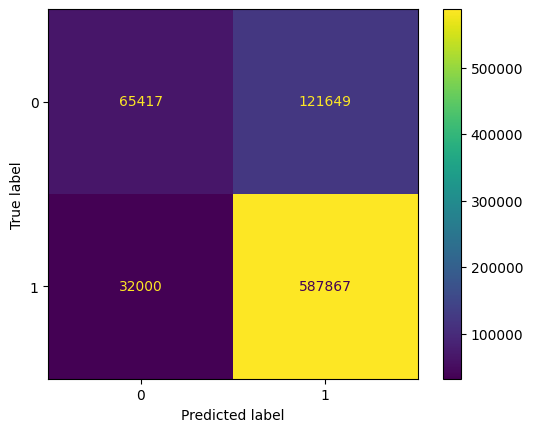

In [86]:
_ = metrics.ConfusionMatrixDisplay(
    metrics.confusion_matrix(test_y, model.predict(test_X))
).plot()

In [87]:
metrics.accuracy_score(test_y, model.predict(test_X))

0.8095889001936963

In [88]:
metrics.precision_score(test_y, model.predict(test_X))

0.8285465021225737

In [89]:
metrics.recall_score(test_y, model.predict(test_X))

0.9483760225983962

In [90]:
metrics.f1_score(test_y, model.predict(test_X))

0.8844208177778714

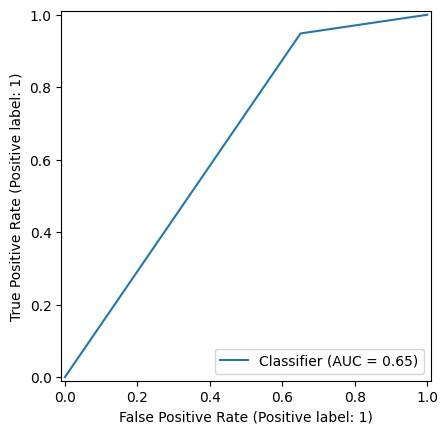

In [91]:
_ = metrics.RocCurveDisplay.from_predictions(test_y, model.predict(test_X))

## Naive Bayes Model

In [62]:
from sklearn.naive_bayes import GaussianNB
model_nb = GaussianNB()

In [63]:
rel_cols_nb = feed_cl.select([
    "label",
    "e_section",
    "e_rn",
    "i_upTimes",
    "i_dislikeTimes",
    "u_refreshTimes",
    "u_feedLifeCycle",
    "u_browserLifeCycle",
    "clicked",
    #"InterestedST",
    "hour",
])

In [64]:
train_df_nb, test_df_nb = train_test_split(data_cols)

In [65]:
train_nb_X = train_df_nb.select(pl.exclude("clicked"))
train_nb_y = train_df_nb["clicked"]
test_nb_X = test_df_nb.select(pl.exclude("clicked"))
test_nb_y = test_df_nb["clicked"]

In [66]:
fit_model_nb = model_nb.fit(train_nb_X, train_nb_y)

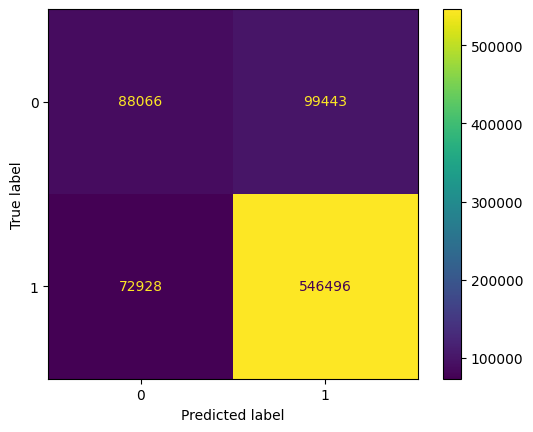

In [67]:
_ = metrics.ConfusionMatrixDisplay(
    metrics.confusion_matrix(test_nb_y, fit_model_nb.predict(test_nb_X))
).plot()

In [68]:
metrics.accuracy_score(test_nb_y, model_nb.predict(test_nb_X))

0.7863874695916514

In [69]:
metrics.precision_score(test_nb_y, model_nb.predict(test_nb_X))

0.8460489303169494

In [70]:
metrics.recall_score(test_nb_y, model_nb.predict(test_nb_X))

0.8822648137624632

In [71]:
metrics.f1_score(test_nb_y, model_nb.predict(test_nb_X))

0.8637774298758538

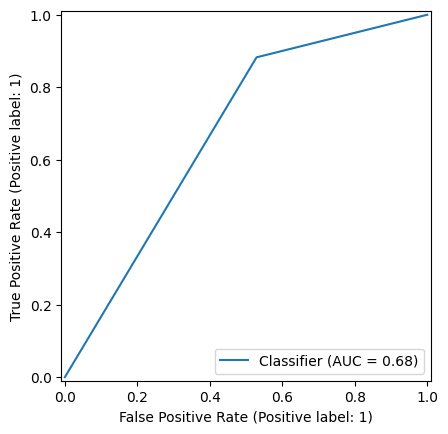

In [72]:
metrics.RocCurveDisplay.from_predictions(test_y, model_nb.predict(test_X))

## Gradient Boost

In [73]:
from sklearn.ensemble import HistGradientBoostingRegressor

model_gb = HistGradientBoostingRegressor()

In [74]:
rel_cols_gb = feed_cl.select([
    "label",
    "e_section",
    "e_rn",
    "i_upTimes",
    "i_dislikeTimes",
    "u_refreshTimes",
    "u_feedLifeCycle",
    "u_browserLifeCycle",
    "clicked",
    #"InterestedST",
    "hour",
])

In [75]:
train_df_gb, test_df_gb = train_test_split(data_cols)

train_gb_X = train_df_gb.select(pl.exclude("clicked"))
train_gb_y = train_df_gb["clicked"]
test_gb_X = test_df_gb.select(pl.exclude("clicked"))
test_gb_y = test_df_gb["clicked"]

In [76]:
fit_model_gb = model_gb.fit(train_gb_X, train_gb_y)

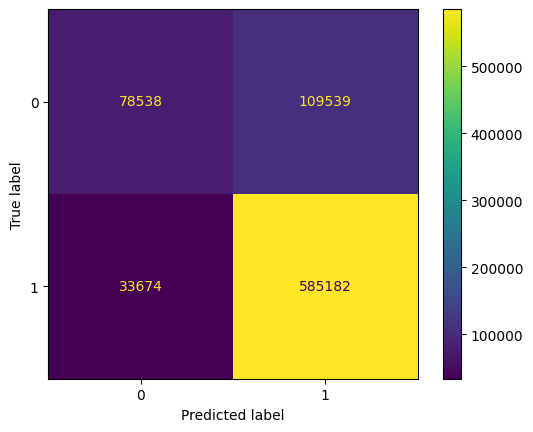

In [77]:
_ = metrics.ConfusionMatrixDisplay(
    metrics.confusion_matrix(test_gb_y, fit_model_gb.predict(test_gb_X).round())
).plot()

In [78]:
metrics.accuracy_score(test_gb_y, model_gb.predict(test_gb_X).round())

0.8225218202750414

In [79]:
metrics.precision_score(test_gb_y, model_gb.predict(test_gb_X).round())

0.8423266318421352

In [80]:
metrics.recall_score(test_gb_y, model_gb.predict(test_gb_X).round())

0.9455866954509611

In [81]:
metrics.f1_score(test_gb_y, model_gb.predict(test_gb_X).round())

0.8909747963004834